In [2]:
import math
import random
import os

from app_settings import set_random_seed,set_global_settings
set_random_seed()
set_global_settings()



from pypinyin import pinyin, Style
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from IPython.display import display, Javascript
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
from UCBCapstone_data_io import *
from UCBCapstone_data_prepare import *
from UCBCapstone_data_view import *
from UCBCapstone_models import *
from UCBCapstone_backtest import *


%load_ext autoreload
%autoreload 2


2025-07-30 14:41:15.423469: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 14:41:15.435979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753911675.449696 1681711 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753911675.453441 1681711 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753911675.463518 1681711 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Notebook introduction:
- This notebook presents backtrader test results using different models prepared by [Model Training and Testing](https://github.com/mingl2000/UCBCapstone/blob/main/UCBCapstone_models.ipynb)
- Here is the outline of this notebook:
    - Buy and Hold strategy test for one CSI Index ETF : This serves as baseline for back testing for this CSI ETF.
    - Backtrader test for "VotingRegressor" model for one CSI index ETF using related index future contact trading data
    - Backtrader test using all regression models for all 4 CSI Index ETFs/futures: IH,IF,IC,IM
        - Summary plot for test result using regression models 
    - Backtrader test using all classification models for all 4 CSI Index ETFs/futures: IH,IF,IC,IM
        - Summary plot for test result using classification models 

#### Summmary of Backtrader test
- Backtrader test using Regression based algorithms
    - Many trades were triggered. 
    - The winning rate for future IM contact is high across all models. 
    - For future IC product, the investment based all the algorithms tested out-performanced buy and hold strategy most: 
        - Annual return for Buy and hold for IC for the testing period: **0.497%**
        - Annual return for VotingRegressor model for the testing period: **33%** 
            
- Backtrader test using classification based algorithms
    - The main problem for these models that only one trade is triggered. More testing is needed. 
    - This model does help to avoid the big market down on 4/10/2025 due to trade war news.

### Backtrader tests

#### Back test using regression models
- LinearRegression
- RidgeRegression
- KnnRegressor
- DecisionTreeRegressor
- TransformedTargetRegressor
- AdaBoostRegressor
- XGBRegressor
- VotingRegressor

In [3]:
# load and split data into train set, validation set and test set. Test set does not overlap with other 2 sets at all.
product='IC'
important_features=[]
classification=False

X_train, y_train, X_val, y_val, X_test, y_test,df_close_test, start_date, end_date = load_and_preprocess_and_split_data(product, important_features, classification)


510500.SS already exists, skip downloading...


### Baseline : Buy and hold strategy

In [4]:
model_name='BuyAndHold'
model_name, ic,mse,test_score, annual_return, sharperatio, max_drawdown,win_rate, total_trades =backtest(product, model_name, None,X_train, y_train, X_val, y_val, X_test, y_test, df_close_test,classification, start_date, end_date, verbose=0)   
back_test_result_buy_and_hold={"product": product,"model_name":model_name, 'IC%':ic,'MSE':mse,'test_score':test_score, "annual_return%":annual_return*100,'win_rate':win_rate,'total_trades':total_trades, 'sharperatio':sharperatio,'max_drawdown%':max_drawdown}


                    BuyAndHold: product:   IC   Final Portfolio Value:    100134.43     annual_return: 0.50%     win_rate: 0.00%   total_trades:   0  Sharpe Ratio: 0.00      max drawdown: 11.23


#### Back test for "VotingRegressor" model. This applies to all models with one row of data

In [5]:
%load_ext autoreload
%autoreload 2


%matplotlib inline

model_name= "VotingRegressor"
model = regression_models[model_name]
model_name, ic,mse,test_score, annual_return, sharperatio, max_drawdown,win_rate, total_trades =backtest(product, model_name, model,X_train, y_train, X_val, y_val, X_test, y_test, df_close_test,classification, start_date, end_date, verbose=0)    
back_test_result={"product": product,"model_name":model_name, 'IC%':ic,'MSE':mse,'test_score':test_score, "annual_return%":annual_return*100,'win_rate':win_rate,'total_trades':total_trades, 'sharperatio':sharperatio,'max_drawdown%':max_drawdown}
print(back_test_result)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
               VotingRegressor: product:   IC   Final Portfolio Value:    108156.76     annual_return: 33.55%     win_rate: 60.00%   total_trades:   5  Sharpe Ratio: 0.17      max drawdown: 2.48
{'product': 'IC', 'model_name': 'VotingRegressor', 'IC%': 0.06389177109106872, 'MSE': 0.005596766686776758, 'test_score': None, 'annual_return%': 33.54799470911421, 'win_rate': 60.0, 'total_trades': 5, 'sharperatio': 0.1695172440312324, 'max_drawdown%': 2.4844771615496235}


#### back test for Tensorflow MLP model

In [21]:
import tensorflow as tf
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(1)

model_name='Tensorflow_MLP'
classification=False
model_name, ic,mse,test_score, annual_return, sharperatio, max_drawdown,win_rate, total_trades =backtest(product, model_name, None, X_train, y_train, X_val, y_val, X_test, y_test, df_close_test, classification, start_date, end_date, verbose=0,epochs=100)
back_test_result={"product": product,"model_name":model_name, 'IC%':ic,'MSE':mse, 'test_score':test_score,"annual_return%":annual_return*100,'win_rate':win_rate,'total_trades':total_trades, 'sharperatio':sharperatio,'max_drawdown%':max_drawdown}
print(back_test_result)


2025-07-30 16:09:39.387702: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Epoch 8: ReduceLROnPlateau reducing learning rate to 1e-05.

Stopping search: val_loss (0.0131) is below threshold (0.0300)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

2025-07-30 16:10:18.394025: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
                Tensorflow_MLP: product:   IC   Final Portfolio Value:    100268.39     annual_return: 0.99%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.00      max drawdown: 11.23
{'product': 'IC', 'model_name': 'Tensorflow_MLP', 'IC%': 0, 'MSE': 0.00020458013616350446, 'test_score': None, 'annual_return%': 0.9937610598057978, 'win_rate': 100.0, 'total_trades': 1, 'sharperatio': 0.004562618400809212, 'max_drawdown%': 11.232818363410985}


#### Test all models for all 4 CSI future products: IH,IF,IC, IM

In [22]:
%load_ext autoreload
%autoreload 2
classification=False
important_features=[]
df_backtest_result= backtest_all_products('IH,IF,IC,IM',important_features, classification,verbose=0, epochs=20)
df_backtest_result


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
510050.SS already exists, skip downloading...
                    BuyAndHold: product:   IH   Final Portfolio Value:    102239.34     annual_return: 8.51%     win_rate: 0.00%   total_trades:   0  Sharpe Ratio: 0.03      max drawdown: 6.57
              LinearRegression: product:   IH   Final Portfolio Value:    98218.42     annual_return: -6.42%     win_rate: 16.67%   total_trades:  12  Sharpe Ratio: -0.12      max drawdown: 3.94


/mnt/d/UCB/UCBCapstoneFinal2/UCBCapstone/UCBCapstone_backtest.py:262: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result.loc[len(df_result)] = {"product": product,"model_name":model_name, 'IC%':ic*100,'MSE':mse, 'test_score':None, "annual_return%":annual_return*100,'win_rate':win_rate,'total_trades':total_trades, 'sharperatio':sharperatio,'max_drawdown%':max_drawdown,'classification':classification}


               RidgeRegression: product:   IH   Final Portfolio Value:    101604.22     annual_return: 6.05%     win_rate: 100.00%   total_trades:   2  Sharpe Ratio: 0.06      max drawdown: 0.78
                  KnnRegressor: product:   IH   Final Portfolio Value:    104196.28     annual_return: 16.38%     win_rate: 30.00%   total_trades:  10  Sharpe Ratio: 0.13      max drawdown: 2.47
         DecisionTreeRegressor: product:   IH   Final Portfolio Value:    100101.34     annual_return: 0.37%     win_rate: 35.71%   total_trades:  14  Sharpe Ratio: -0.01      max drawdown: 3.88
    TransformedTargetRegressor: product:   IH   Final Portfolio Value:    98955.36     annual_return: -3.80%     win_rate: 18.18%   total_trades:  11  Sharpe Ratio: -0.09      max drawdown: 3.22
             AdaBoostRegressor: product:   IH   Final Portfolio Value:    100312.39     annual_return: 1.16%     win_rate: 44.44%   total_trades:   9  Sharpe Ratio: -0.00      max drawdown: 2.40
                  XGBRegr

/mnt/d/UCB/UCBCapstoneFinal2/UCBCapstone/UCBCapstone_backtest.py:255: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result.loc[len(df_result)] = {"product": product,"model_name":model_name, 'IC%':None,'MSE':None, 'test_score':None, "annual_return%":annual_return*100,'win_rate':win_rate,'total_trades':total_trades, 'sharperatio':sharperatio,'max_drawdown%':max_drawdown,'classification':classification}


              LinearRegression: product:   IF   Final Portfolio Value:    103417.71     annual_return: 17.04%     win_rate: 60.00%   total_trades:   5  Sharpe Ratio: 0.11      max drawdown: 2.69
               RidgeRegression: product:   IF   Final Portfolio Value:    104678.30     annual_return: 23.87%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.15      max drawdown: 2.69
                  KnnRegressor: product:   IF   Final Portfolio Value:    98260.55     annual_return: -7.89%     win_rate: 40.00%   total_trades:   5  Sharpe Ratio: -0.21      max drawdown: 2.92
         DecisionTreeRegressor: product:   IF   Final Portfolio Value:    101701.21     annual_return: 8.22%     win_rate: 60.00%   total_trades:   5  Sharpe Ratio: 0.09      max drawdown: 0.80
    TransformedTargetRegressor: product:   IF   Final Portfolio Value:    103417.71     annual_return: 17.04%     win_rate: 60.00%   total_trades:   5  Sharpe Ratio: 0.11      max drawdown: 2.69
             AdaBoostRegr

/mnt/d/UCB/UCBCapstoneFinal2/UCBCapstone/UCBCapstone_backtest.py:255: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result.loc[len(df_result)] = {"product": product,"model_name":model_name, 'IC%':None,'MSE':None, 'test_score':None, "annual_return%":annual_return*100,'win_rate':win_rate,'total_trades':total_trades, 'sharperatio':sharperatio,'max_drawdown%':max_drawdown,'classification':classification}


              LinearRegression: product:   IC   Final Portfolio Value:    108156.76     annual_return: 33.55%     win_rate: 60.00%   total_trades:   5  Sharpe Ratio: 0.17      max drawdown: 2.48
               RidgeRegression: product:   IC   Final Portfolio Value:    101751.64     annual_return: 6.62%     win_rate: 50.00%   total_trades:   4  Sharpe Ratio: 0.03      max drawdown: 5.68
                  KnnRegressor: product:   IC   Final Portfolio Value:    96459.69     annual_return: -12.45%     win_rate: 60.00%   total_trades:   5  Sharpe Ratio: -0.04      max drawdown: 10.82
         DecisionTreeRegressor: product:   IC   Final Portfolio Value:    101909.90     annual_return: 7.23%     win_rate: 55.56%   total_trades:   9  Sharpe Ratio: 0.04      max drawdown: 3.42
    TransformedTargetRegressor: product:   IC   Final Portfolio Value:    108156.76     annual_return: 33.55%     win_rate: 60.00%   total_trades:   5  Sharpe Ratio: 0.17      max drawdown: 2.48
             AdaBoostRegr

/mnt/d/UCB/UCBCapstoneFinal2/UCBCapstone/UCBCapstone_backtest.py:255: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result.loc[len(df_result)] = {"product": product,"model_name":model_name, 'IC%':None,'MSE':None, 'test_score':None, "annual_return%":annual_return*100,'win_rate':win_rate,'total_trades':total_trades, 'sharperatio':sharperatio,'max_drawdown%':max_drawdown,'classification':classification}


               RidgeRegression: product:   IM   Final Portfolio Value:    104614.63     annual_return: 39.97%     win_rate: 50.00%   total_trades:   2  Sharpe Ratio: 0.14      max drawdown: 3.20
                  KnnRegressor: product:   IM   Final Portfolio Value:    98911.52     annual_return: -7.83%     win_rate: 25.00%   total_trades:   4  Sharpe Ratio: -0.19      max drawdown: 1.64
         DecisionTreeRegressor: product:   IM   Final Portfolio Value:    101922.18     annual_return: 15.25%     win_rate: 66.67%   total_trades:   6  Sharpe Ratio: 0.06      max drawdown: 4.86
    TransformedTargetRegressor: product:   IM   Final Portfolio Value:    103849.89     annual_return: 32.52%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.12      max drawdown: 3.21
             AdaBoostRegressor: product:   IM   Final Portfolio Value:    102932.62     annual_return: 24.04%     win_rate: 57.14%   total_trades:   7  Sharpe Ratio: 0.11      max drawdown: 3.73
                  XGBReg

,product,model_name,IC%,MSE,test_score,annual_return%,win_rate,total_trades,sharperatio,max_drawdown%,classification
0,IH,BuyAndHold,NaN,NaN,None,8.513729,0.000000,0,0.033042,6.574248,False
1,IH,LinearRegression,59.137167,0.000043,None,-6.417074,16.666667,12,-0.123391,3.936691,False
2,IH,RidgeRegression,-10.571896,0.000358,None,6.047429,100.000000,2,0.059519,0.777330,False
3,IH,KnnRegressor,4.952708,0.000091,None,16.376129,30.000000,10,0.131615,2.467285,False
4,IH,DecisionTreeRegressor,9.387434,0.000076,None,0.374382,35.714286,14,-0.009853,3.884509,False
5,IH,TransformedTargetRegressor,59.137167,0.000044,None,-3.800256,18.181818,11,-0.086755,3.215913,False
6,IH,AdaBoostRegressor,26.398829,0.000062,None,1.157365,44.444444,9,-0.004995,2.404114,False
7,IH,XGBRegressor,22.185860,0.000078,None,-0.062567,33.333333,9,-0.017356,2.698935,False
8,IH,VotingRegressor,42.347448,0.000075,None,4.438760,50.000000,4,0.042749,1.274091,False
9,IF,BuyAndHold,NaN,NaN,None,24.505068,0.000000,0,0.157111,2.687151,False


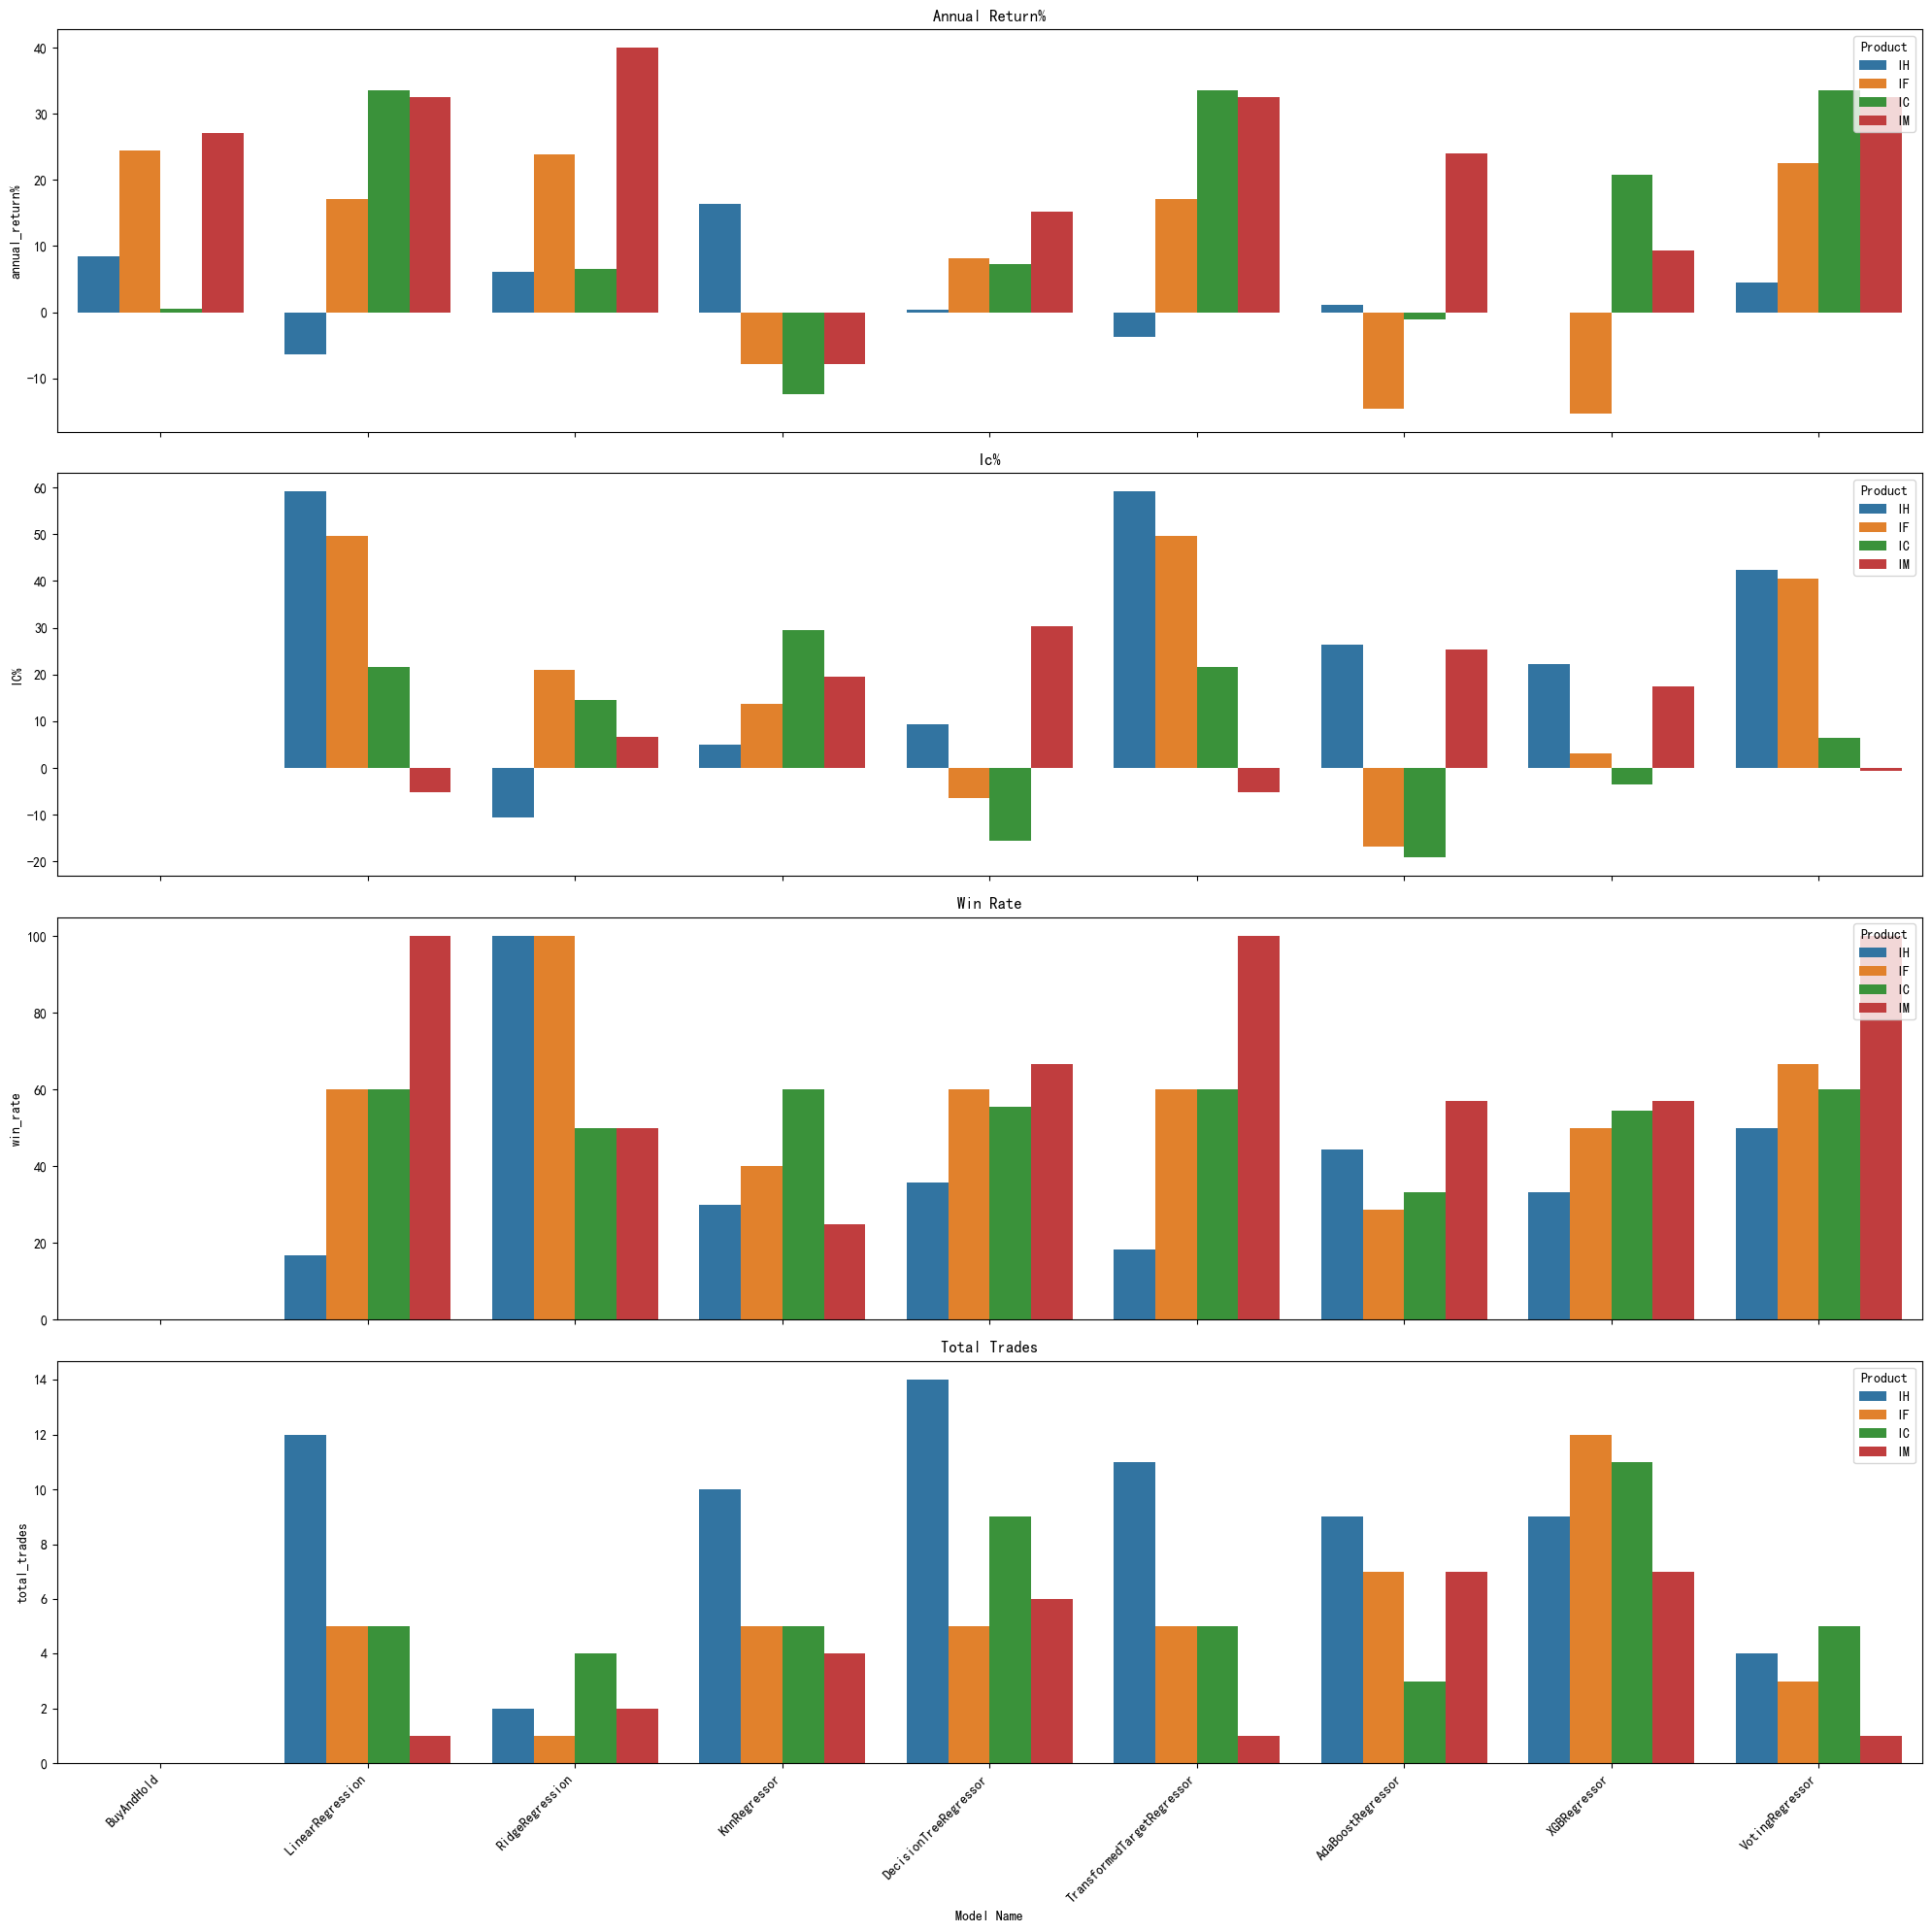

In [23]:
%matplotlib inline
def plt_backtest_result(df_backtest_result, metrics, filename):
    
    n_metrics = len(metrics)
    n_metrics = len(metrics)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(20, 5 * n_metrics), sharex=True)

    # Handle case where there's only one metric
    if n_metrics == 1:
        axes = [axes]

    # Create a subplot for each metric
    for i, (metric, ax) in enumerate(zip(metrics, axes)):
        sns.barplot(x='model_name', y=metric, hue='product', data=df_backtest_result, ax=ax)
        ax.set_title(f'{metric.replace("_", " ").title()}')  # Dynamic title based on metric
        ax.set_xlabel('')  # Remove x-axis label for all but the bottom subplot
        ax.legend(title='Product', loc='upper right')  # Ensure legend is visible

    axes[-1].set_xlabel('Model Name')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    filename=f'{filename}{datetime.datetime.now().strftime("%y_%m_%d_%H_%M_%S")}.png'
    fig.savefig(f'images/{filename}{datetime.datetime.now().strftime("%y_%m_%d_%H_%M_%S")}.png')
    plt.show()

metrics = ['annual_return%','IC%','win_rate', 'total_trades']
plt_backtest_result(df_backtest_result,metrics, 'backtrader_regression_test_result')


### Back test using classification models
- LogisticRegression
- KNeighborsClassifier
- AdaBoostClassifier
- XGBClassifier
- VotingClassifier


In [24]:
classification=True
important_features=[]
df_backtest_result= backtest_all_products('IH,IF,IC,IM',important_features, classification,verbose=0, epochs=20)
df_backtest_result



510050.SS already exists, skip downloading...
                    BuyAndHold: product:   IH   Final Portfolio Value:    102239.34     annual_return: 8.51%     win_rate: 0.00%   total_trades:   0  Sharpe Ratio: 0.03      max drawdown: 6.57
            LogisticRegression: product:   IH   Final Portfolio Value:    101958.35     annual_return: 7.42%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.03      max drawdown: 6.57


/mnt/d/UCB/UCBCapstoneFinal2/UCBCapstone/UCBCapstone_backtest.py:260: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result.loc[len(df_result)] = {"product": product,"model_name":model_name, 'IC%':None,'MSE':None, 'test_score':test_score, "annual_return%":annual_return*100,'win_rate':win_rate,'total_trades':total_trades, 'sharperatio':sharperatio,'max_drawdown%':max_drawdown,'classification':classification}


          KNeighborsClassifier: product:   IH   Final Portfolio Value:    102549.33     annual_return: 9.73%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.04      max drawdown: 6.45
            AdaBoostClassifier: product:   IH   Final Portfolio Value:    101958.35     annual_return: 7.42%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.03      max drawdown: 6.57
                 XGBClassifier: product:   IH   Final Portfolio Value:    109034.30     annual_return: 37.59%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.22      max drawdown: 2.96
              VotingClassifier: product:   IH   Final Portfolio Value:    101958.35     annual_return: 7.42%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.03      max drawdown: 6.57
000300.SS already exists, skip downloading...
                    BuyAndHold: product:   IF   Final Portfolio Value:    104791.83     annual_return: 24.51%     win_rate: 0.00%   total_trades:   0  Sharpe Ratio: 0.16    

/mnt/d/UCB/UCBCapstoneFinal2/UCBCapstone/UCBCapstone_backtest.py:255: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result.loc[len(df_result)] = {"product": product,"model_name":model_name, 'IC%':None,'MSE':None, 'test_score':None, "annual_return%":annual_return*100,'win_rate':win_rate,'total_trades':total_trades, 'sharperatio':sharperatio,'max_drawdown%':max_drawdown,'classification':classification}


            LogisticRegression: product:   IF   Final Portfolio Value:    104678.30     annual_return: 23.87%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.15      max drawdown: 2.69
          KNeighborsClassifier: product:   IF   Final Portfolio Value:    104678.30     annual_return: 23.87%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.15      max drawdown: 2.69
            AdaBoostClassifier: product:   IF   Final Portfolio Value:    104607.92     annual_return: 23.49%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.15      max drawdown: 2.68
                 XGBClassifier: product:   IF   Final Portfolio Value:    104607.92     annual_return: 23.49%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.15      max drawdown: 2.68
              VotingClassifier: product:   IF   Final Portfolio Value:    104678.30     annual_return: 23.87%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.15      max drawdown: 2.69
510500.SS already ex

/mnt/d/UCB/UCBCapstoneFinal2/UCBCapstone/UCBCapstone_backtest.py:255: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result.loc[len(df_result)] = {"product": product,"model_name":model_name, 'IC%':None,'MSE':None, 'test_score':None, "annual_return%":annual_return*100,'win_rate':win_rate,'total_trades':total_trades, 'sharperatio':sharperatio,'max_drawdown%':max_drawdown,'classification':classification}


            LogisticRegression: product:   IC   Final Portfolio Value:    100268.39     annual_return: 0.99%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.00      max drawdown: 11.23
          KNeighborsClassifier: product:   IC   Final Portfolio Value:    100268.39     annual_return: 0.99%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.00      max drawdown: 11.23
            AdaBoostClassifier: product:   IC   Final Portfolio Value:    101141.92     annual_return: 4.28%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.01      max drawdown: 10.26
                 XGBClassifier: product:   IC   Final Portfolio Value:    99934.94     annual_return: -0.24%     win_rate: 0.00%   total_trades:   1  Sharpe Ratio: 0.00      max drawdown: 11.29
              VotingClassifier: product:   IC   Final Portfolio Value:    100268.39     annual_return: 0.99%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.00      max drawdown: 11.23
512100.SS already exis

/mnt/d/UCB/UCBCapstoneFinal2/UCBCapstone/UCBCapstone_backtest.py:255: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result.loc[len(df_result)] = {"product": product,"model_name":model_name, 'IC%':None,'MSE':None, 'test_score':None, "annual_return%":annual_return*100,'win_rate':win_rate,'total_trades':total_trades, 'sharperatio':sharperatio,'max_drawdown%':max_drawdown,'classification':classification}


            LogisticRegression: product:   IM   Final Portfolio Value:    104822.27     annual_return: 42.06%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.16      max drawdown: 3.21
          KNeighborsClassifier: product:   IM   Final Portfolio Value:    104897.38     annual_return: 42.82%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.19      max drawdown: 3.20
            AdaBoostClassifier: product:   IM   Final Portfolio Value:    105496.04     annual_return: 49.01%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.18      max drawdown: 3.20
                 XGBClassifier: product:   IM   Final Portfolio Value:    105505.10     annual_return: 49.10%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.18      max drawdown: 3.21
              VotingClassifier: product:   IM   Final Portfolio Value:    104018.65     annual_return: 34.14%     win_rate: 100.00%   total_trades:   1  Sharpe Ratio: 0.13      max drawdown: 3.21


,product,model_name,IC%,MSE,test_score,annual_return%,win_rate,total_trades,sharperatio,max_drawdown%,classification
0,IH,BuyAndHold,None,None,NaN,8.513729,0.0,0,0.033042,6.574248,True
1,IH,LogisticRegression,None,None,0.477612,7.417496,100.0,1,0.028392,6.574248,True
2,IH,KNeighborsClassifier,None,None,0.522388,9.732559,100.0,1,0.038311,6.448352,True
3,IH,AdaBoostClassifier,None,None,0.641791,7.417496,100.0,1,0.028392,6.574248,True
4,IH,XGBClassifier,None,None,0.597015,37.589471,100.0,1,0.223923,2.957327,True
5,IH,VotingClassifier,None,None,0.567164,7.417496,100.0,1,0.028392,6.574248,True
6,IF,BuyAndHold,None,None,NaN,24.505068,0.0,0,0.157111,2.687151,True
7,IF,LogisticRegression,None,None,0.566038,23.874701,100.0,1,0.153049,2.687151,True
8,IF,KNeighborsClassifier,None,None,0.584906,23.874701,100.0,1,0.153049,2.687151,True
9,IF,AdaBoostClassifier,None,None,0.490566,23.485186,100.0,1,0.151069,2.681131,True


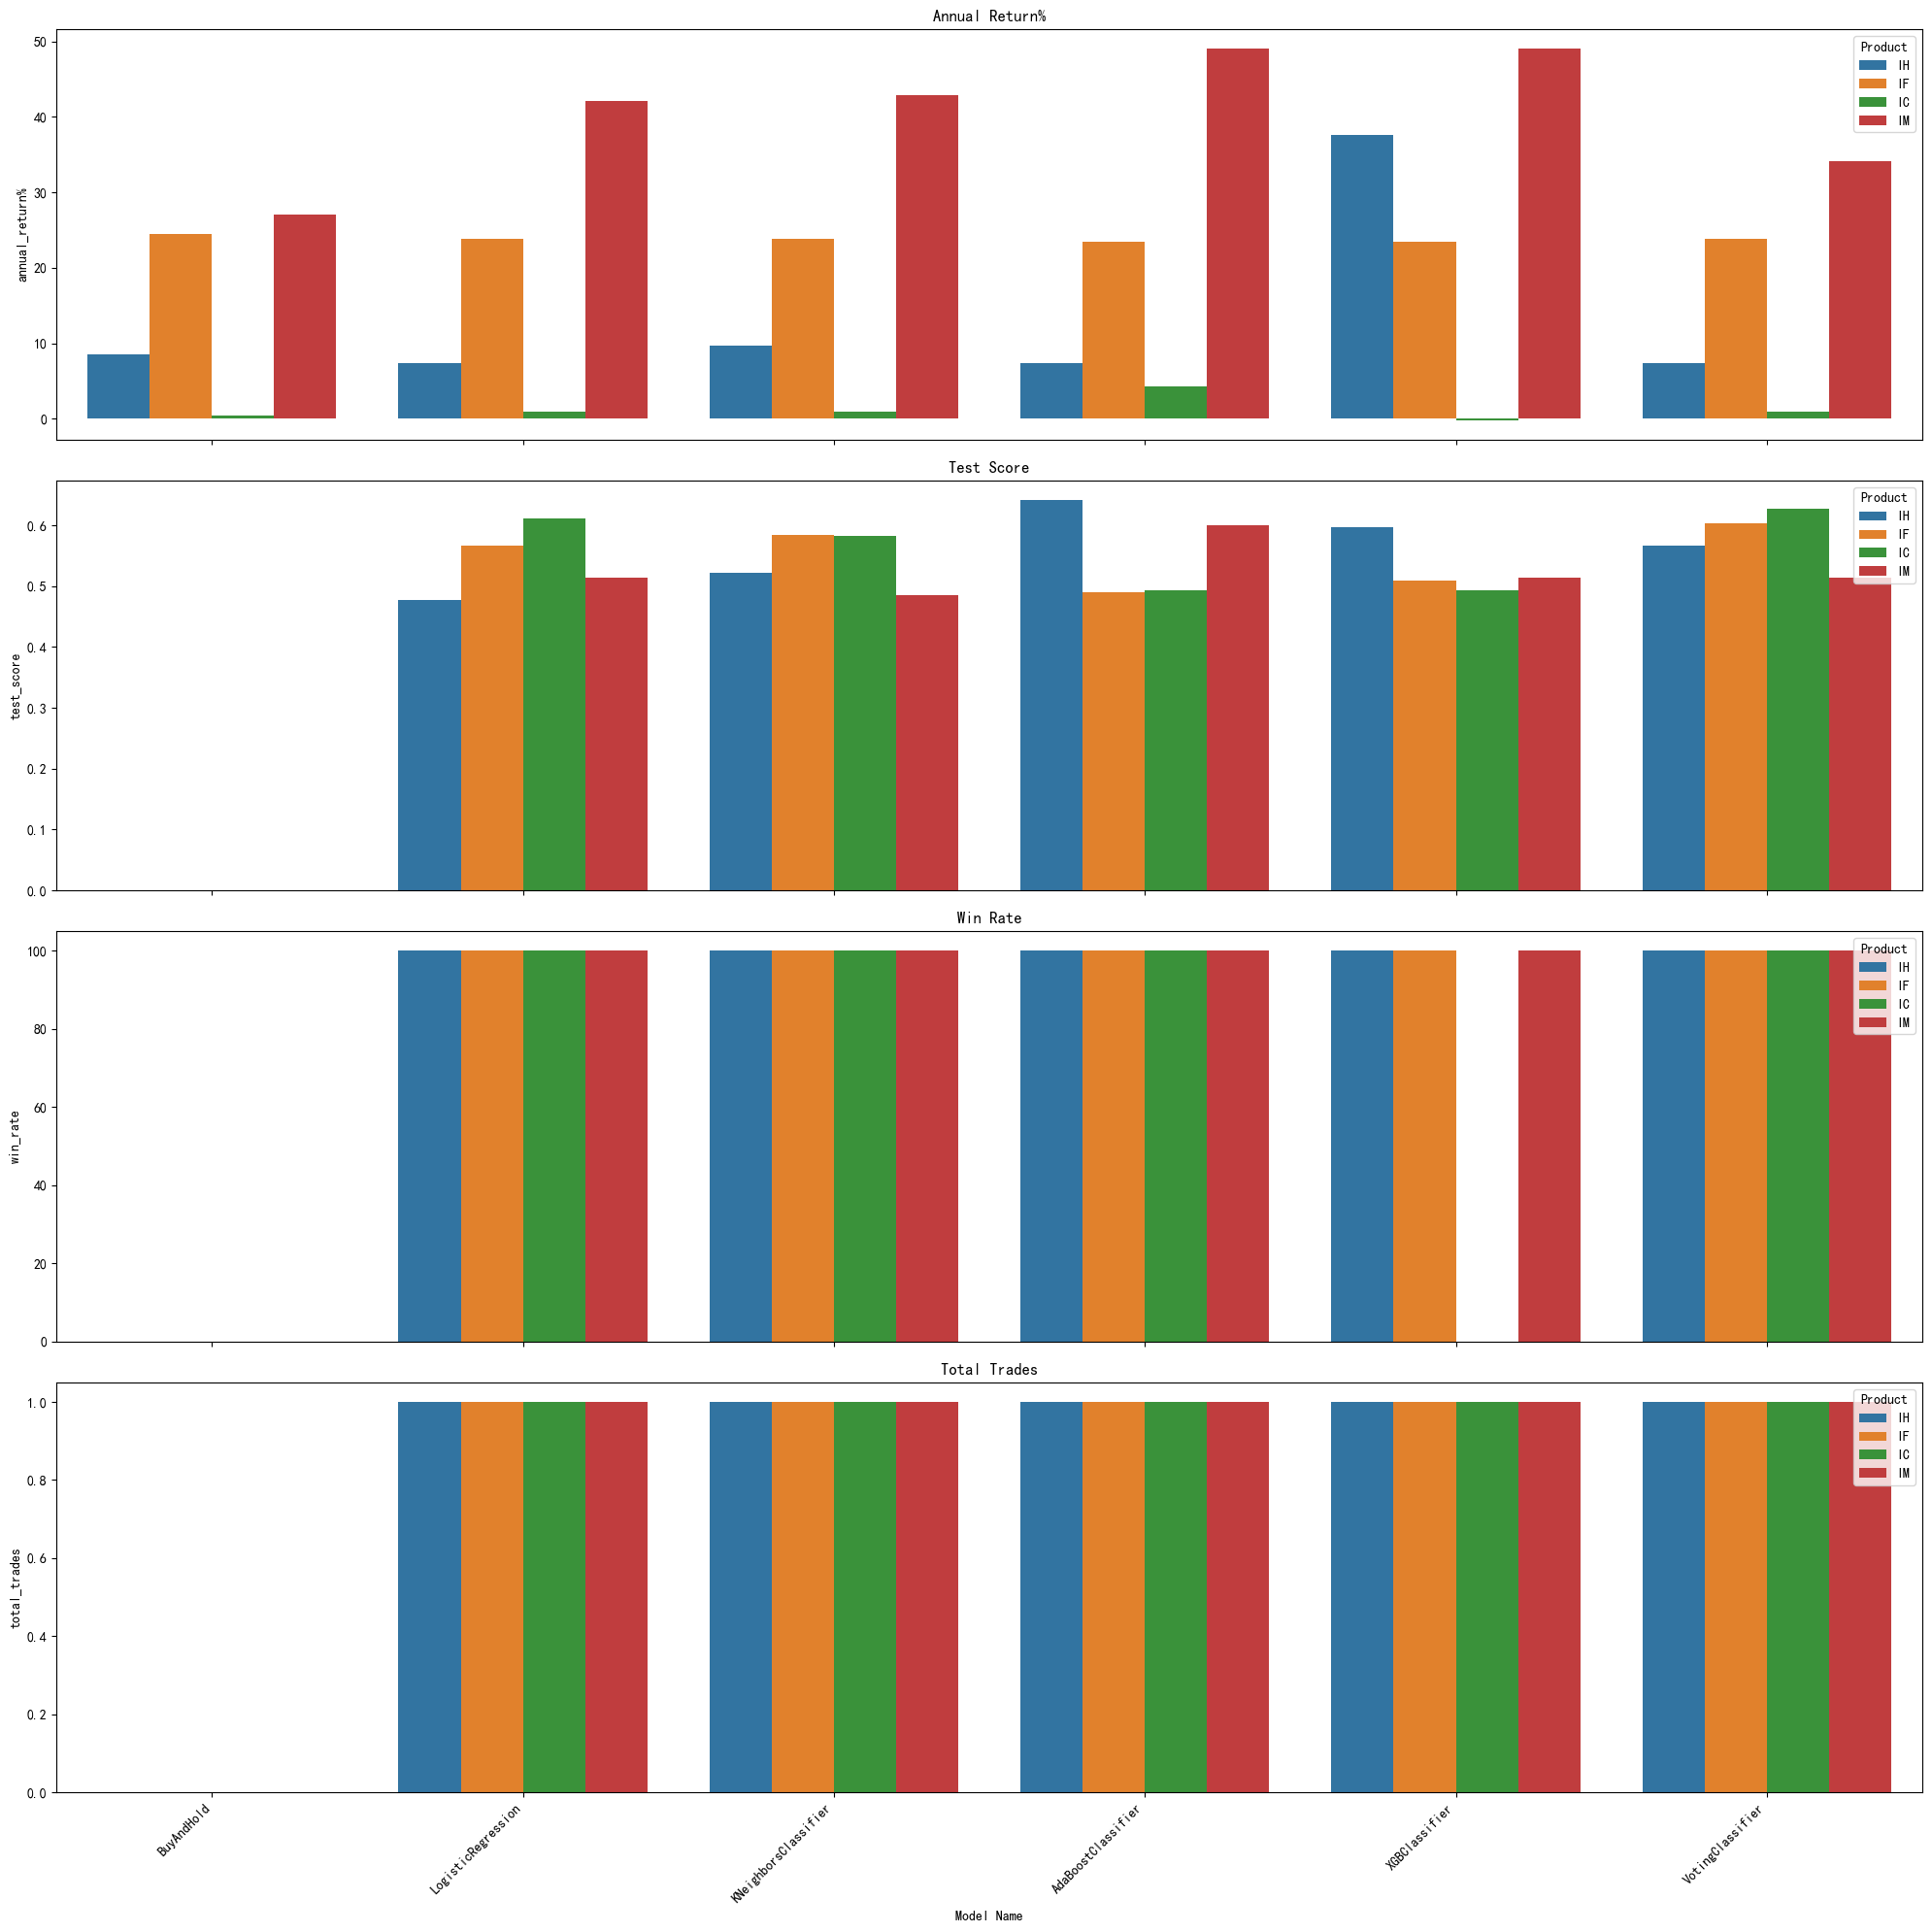

In [25]:
metrics = ['annual_return%','test_score','win_rate', 'total_trades']
plt_backtest_result(df_backtest_result,metrics, 'backtrader_regression_test_result')


#### Summmary of Backtrader test
- Backtrader test using Regression based algorithms
    - Many trades were triggered. 
    - The winning rate for future IM contact is high across all models. 
    - For future IC product, the investment based all the algorithms tested out-performanced buy and hold strategy most: 
        - Annual return for Buy and hold for IC for the testing period: **0.497%**
        - Annual return for VotingRegressor model for the testing period: **33%** 
            
- Backtrader test using classification based algorithms
    - The main problem is that only one trade is triggered and not able to close even at the last bar based all the predictions of the algorithms tested.
    - This model does help to avoid the big market down on 4/10/2025
    